# PDE Modelling Mimic of 190413 experiment

## Objectives 
* Microscope movie was performed on 190413 that simply observed growth of a constitutively fluorescent strain on agar pads, varying in pad size and cell occupation
* Simulate each of the experimental setups executed
* eventually build into a fitting routine

## Model considerations 
* Species
    1. Cell density (sender and pulse cells)
    1. Nutrient density 
    1. mScarlet
* Reactions 
    1. cell growth and diffusion 
        * Cells diffuse very slowly
        * nutrient-dependent growth (from Liu et al 2011, Science) 
        $$  $$ 
    1. Constitutive fluorescence
        * Basal protein expression 
        * initial protein concentration set to fixed point of max nutrient
    1. Dilution and degradation 
        * Assume that all proteins are degradation tagged
    1. Diffusion 
        * Here, you're going to use convoultion of the diffusion kernel
        * Diffusion in/out of cell is considered faster than spatial diffusion at these scales
    1. Parameters
        * We are also assuming, for the moment, that each time point is 6 minutes. Parameters with time dimensions shown below may use different units than the parameter from the cited paper.
        * dx: Length modification of diffusion terms. In the compartmental model, diffusion is calculated via Ficks' first law, where the flux between two adjacent compartments is equal to the flux multiplied by the area of the interface between the components :  
        $\frac{\mathrm{d} C}{\mathrm{d} t} $ 
        in continuous form gives up 
        $\Delta C = D \frac{A}{V} \frac{\Delta C}{\Delta x} = D \frac{2.25 \cdot 5 \cdot \mathrm{scale}^2 \mathrm{mm}^2}{\mathrm{scale} \cdot 2.25^2 \cdot 5 \mathrm{mm}^3} \frac{\Delta C \cdot \mathrm{scale}}{2.25 \mathrm{mm}} = \frac{D \Delta C \mathrm{scale}^2}{2.25^2 \mathrm{mm}^2}$. the dx parameter below is the symbol $A$ in this equation.
        * Dc : Diffusion rate for cells. $7\frac{mm^2}{min}$
        * rc : Division rate of cells. $\frac{1.14}{min}$
        * Kn : Half-point of nutrient availability. 75
        * Dn : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * kn : Consumption rate of nutrient by cells
        * Da : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * xs : Expression rate of protein. 


In [1]:
# imports
# from __future__ import division, print_function

import itertools as itt

import numpy as np
import pandas as pd
import os
import sys
import string
import selenium
import scipy.integrate as itg
import scipy.sparse as sparse

import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # Add the path of ffmpeg here!!

import matplotlib.animation as anm
import skimage.io
import skimage.transform
import numba
# import gc
import emcee

from multiprocessing import Pool, Process, cpu_count

%load_ext memory_profiler
%load_ext line_profiler
import timeit

# from IPython.display import HTML

pad_times_df = pd.read_csv('pad_times.csv')
pad_times_df = pad_times_df.loc[(pad_times_df.frame>=5)&(pad_times_df.frame<41),:]

# rc = {'lines.linewidth': 2, 
#       'axes.labelsize': 18, 
#       'axes.titlesize': 24, 
#       'xtick.labelsize': 18, 
#       'ytick.labelsize': 18, 
#       'legend.fontsize': 18,
#       'axes.facecolor': 'DFDFE5'}

# sns.set_context('paper', rc=rc)

%matplotlib inline

## 2D Discrete Laplacian

In continuous form : 
$$ U_t = \triangle U - \lambda U $$

In discrete form, for point $i$ : 
$$ \Delta U_i = \sum_{1 = w(i,j)}\omega(i,j)(U_i - U_j) - \lambda U_i $$

Use discrete laplacian approximation w/o diagonals for grid spacing, so that we can have zero-flux  boundary conditions. 

$$ L = 
 \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0 
 \end{pmatrix} $$

This is achieved though a bunch of subtractions between offset arrays.

Attempt fitting w/o crowding

# Helper functions used to define the arenas 
### Needs
* read excel or csv files 
* rescaling arrays and contents 
* convert row/col to array index


* disk function, projects circular areas onto an input grid 
* 

## Try rewriting into class-based approach to simulation to speed up fitting

In [2]:
#@numba.jit('void(float32[:,:,:],float32[:,:,:])', nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def calc_diffusion(A, D):
    # Middle
    D[:,1:-1,1:-1] = A[:,1:-1, 2:] + A[:,1:-1, :-2] + A[:,:-2, 1:-1] + A[:,2:, 1:-1] - 4*A[:,1:-1, 1:-1]
    # Edges
    D[:,0,1:-1] = A[:,0, 2:] + A[:,0, :-2] + A[:,1, 1:-1] - 3*A[:,0, 1:-1]
    D[:,-1,1:-1] = A[:,-1, 2:] + A[:,-1, :-2] + A[:,-2, 1:-1] - 3*A[:,-1, 1:-1]
    D[:,1:-1,0] = A[:,2:,0] + A[:,:-2,0] + A[:,1:-1,1] - 3*A[:,1:-1,0]
    D[:,1:-1,-1] = A[:,2:,-1] + A[:,:-2,-1] + A[:,1:-1,-2] - 3*A[:,1:-1,-1]
    # Corners
    D[:,0,0] = A[:,0,1] + A[:,1,0] - 2*A[:,0,0]
    D[:,-1,0] = A[:,-1,1] + A[:,-2,0] - 2*A[:,-1,0]
    D[:,0,-1] = A[:,0,-2] + A[:,1,-1] - 2*A[:,0,-1]
    D[:,-1,-1] = A[:,-1,-2] + A[:,-2,-1] - 2*A[:,-1,-1]

#@numba.jit('float32[:,:](float32[:,:],float32,float32)',nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def hill(a, n, k):
    h_ma = 1 - (1 / (1 + (a/k)**n))
    return h_ma

@numba.jit(nopython=True, cache=True)
def dhillda(a, n, k):
    h_ma = (n/k)*((a/k)**(n-1))*(1 / (1 + (a/k)**n)**2)
    return h_ma

#@numba.jit('float32[:,:](float32[:,:],float32,float32)',nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def hillN(a, n, k):
    return 1 / (1 + (a/k)**n)

# @numba.jit(cache=True)
def f_ivp(t, y, d_y, diff_terms, nut_avail, p0, dims, calc_f):
    species, n_h, n_w, scale= dims
    y.shape = (species, n_h, n_w)
    calc_f(y, d_y, diff_terms, nut_avail, p0)
    y.shape = species*n_h*n_w
    return d_y.flatten()

def wrapper(dims, p0, initial_array, t_eval, atol, rtol, calc_f, jac):
#     print(solver)
    species, n_h, n_w, scale = dims
    args=(np.zeros((species, n_h, n_w), dtype=np.float32,order='C'), 
          np.zeros((species, n_h, n_w), dtype=np.float32,order='C'), 
          np.zeros((n_h, n_w), dtype=np.float32,order='C'), 
          p0, dims, calc_f)
    initial_array.shape = n_h*n_w*species
    f_lambda = lambda t, y : f_ivp(t, y, *args)
    out = itg.solve_ivp(f_lambda, [t_eval.min(), t_eval.max()], initial_array.copy(), 
                        vectorized=True, method="BDF", 
                        atol=atol, rtol=rtol, t_eval=t_eval, jac=jac)
    exp_t = out.t
    exp_y = out.y.T
    exp_y.shape = (len(exp_t), species, n_h, n_w)
#     print("nfev:{} njev:{}".format(out.nfev, out.njev))
    return exp_y, exp_t

# @numba.jit(cache=True)
def prep_pad_helper(scale, pad, frame):
    mask_fn_tmpl = 'worker_outputs/initial_frame_masks/pad_{}_frame_{}.tif'
    img_fn = mask_fn_tmpl.format(pad,frame)
    init_cells = skimage.io.imread(img_fn)
    scale_factor = (scale/4500)/(2.475/4)
    scaled_init = skimage.transform.rescale((init_cells>1).astype(np.float32), 
                                            scale_factor, 
                                            order=0, 
                                            mode='constant', 
                                            multichannel=False,
                                            preserve_range=True,
                                            cval=0)
    del init_cells
    return scaled_init

def get_t_eval(pov_ind, frames=np.arange(5,41)):
    return pad_times_df.loc[pad_times_df.pad==pov_ind,'time'].values

def pov_0_slices(n_h, n_w, s_h, s_w, scale):
    y0, x0 = (np.array((n_h, n_w))//2) - np.array((s_h, s_w))//2
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    return slice(y0,y1), slice(x0,x1)

def pov_1_slices(n_h, n_w, s_h, s_w, scale):
    y0, x0 = (np.array((n_h, n_w))//2) - np.array((s_h, s_w))//2
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    return slice(y0,y1), slice(x0,x1)

def pov_2_slices(n_h, n_w, s_h, s_w, scale):
    y0, x0 = (np.array((n_h, n_w))//2) - np.array((s_h, s_w))//2
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    return slice(y0,y1), slice(x0,x1)

def pov_4_slices(n_h, n_w, s_h, s_w, scale):
    y0, x0 = (np.array((n_h, n_w))//2) - np.array((s_h, s_w))//2
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    return slice(y0,y1), slice(x0,x1)

def pov_5_slices(n_h, n_w, s_h, s_w, scale):
    y0, x0 = np.array(((n_h-s_h)//2, scale//8))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    return slice(y0,y1), slice(x0,x1)

def pov_6_slices(n_h, n_w, s_h, s_w, scale):
    y0, x0 = np.array(((n_h-s_h)//2, 6*n_w//8))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    return slice(y0,y1), slice(x0,x1)

def pov_7_slices(n_h, n_w, s_h, s_w, scale):
    y0, x0 = np.array(((n_h-s_h)//2, scale//2))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    return slice(y0,y1), slice(x0,x1)

def pov_8_slices(n_h, n_w, s_h, s_w, scale):
    y0, x0 = np.array(((n_h-s_h)//2, (n_w-s_w)//2))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    return slice(y0,y1), slice(x0,x1)

def pov_9_slices(n_h, n_w, s_h, s_w, scale):
    y0, x0 = np.array(((n_h-s_h)//2, (n_w-s_w)//2))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    return slice(y0,y1), slice(x0,x1)
            
def pov_10_slices(n_h, n_w, s_h, s_w, scale):
    y0, x0 = (np.array((0, n_w-s_w))//2)
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    return slice(y0,y1), slice(x0,x1)


class PrepPad(object):
    '''
    Prepares initial conditions for solve_ivp and facilitates comparisons of experimental data to simulation.  
    
    This class is defined according to a specific experiment. The pad dimensions and imaging locations are
    defined for each experimental pad in the __init__ function. Passing a scale and pad index parameter
    to the constructor 
    '''
    def get_time_vec(self):
        return get_t_eval(self.pov_inds[0])
    
    def get_fn_lists(self, frames=np.arange(5,41)):
        mask_fn_tmpl = 'worker_outputs/initial_frame_masks/pad_{}_frame_{}.tif'
        fn_format = lambda pov, frame : mask_fn_tmpl.format(pov, frame)
        fn_lists = [[fn_format(pov, frame) for frame in frames] for pov in self.pov_inds]
        return dict(zip(self.pov_inds, fn_lists))
    
    def prep_initial_cell(self):
        n_h, n_w = self.cell_init.shape
        if np.any(self.cell_init!=0):
            self.cell_init[:] = 0
        for pov_ind, slice_fun in zip(self.pov_inds, self.slice_functions):
            scaled_init = prep_pad_helper(self.scale, pov_ind, 5)
            s_h, s_w = scaled_init.shape
            yslice, xslice = slice_fun(n_h, n_w, s_h, s_w, self.scale)
            self.cell_init[yslice, xslice] += scaled_init
            
            
    def __init__(self, scale, pad_ind):
        self.scale = scale
        if pad_ind==0:
            n_h, n_w = (2*scale, 2*scale)
            self.cell_init = np.zeros((n_h, n_w), dtype=np.float32)        
            self.pad = 0
            self.pov_inds = [0]
            self.slice_functions = [pov_0_slices]
        
        elif pad_ind==1:
            n_h, n_w = (2*scale, 2*scale)
            self.cell_init = np.zeros((n_h, n_w), dtype=np.float32)        
            self.pad = 1
            self.pov_inds = [1, 10]
            self.slice_functions = [pov_1_slices, pov_10_slices]
            
        elif pad_ind==2:
            n_h, n_w = (2*scale, 2*scale)
            self.cell_init = np.zeros((n_h, n_w), dtype=np.float32)
            self.pad = 2
            self.pov_inds = [2]
            self.slice_functions = [pov_2_slices]

        elif pad_ind==4:
            n_h, n_w = (3*scale, 3*scale)
            self.cell_init = np.zeros((n_h, n_w), dtype=np.float32)
            self.pad = 4
            self.pov_inds = [4]
            self.slice_functions = [pov_4_slices]

        elif pad_ind==5:
            n_h, n_w = (5*scale, 5*scale)
            self.cell_init = np.zeros((n_h, n_w), dtype=np.float32)
            self.pad = 5
            self.pov_inds = [5,6]
            self.slice_functions = [pov_5_slices, pov_6_slices]
            
        elif pad_ind==6:
            n_h, n_w = (5*scale, 5*scale)
            self.cell_init = np.zeros((n_h, n_w), dtype=np.float32)
            self.pad = 6
            self.pov_inds = [7]
            self.slice_functions = [pov_7_slices]

        elif pad_ind==7:
            n_h, n_w = (3*scale, 3*scale)
            self.cell_init = np.zeros((n_h, n_w), dtype=np.float32)
            self.pad = 7
            self.pov_inds = [8]
            self.slice_functions = [pov_8_slices]

        elif pad_ind==8:
            n_h, n_w = (2*scale, 2*scale)
            self.cell_init = np.zeros((n_h, n_w), dtype=np.float32)
            self.pad = 8
            self.pov_inds = [9]
            self.slice_functions = [pov_9_slices]
            
        else:
            raise ValueError
        
        self.prep_initial_cell()
    

# try to make a jacobian function
# you'll likely need to use the vectorized version of the ODE, rather than the matrix version. 
# first, just see if you can use the sparsity structure matrix approach
class Jacobian(object):
    def assign_dif_val(self, i, val, j1, j2):
        self.dif_vec[i] = val
        self.j1_dif[i] = j1
        self.j2_dif[i] = j2
        return i+1
    
    def assign_rxn_vals(self, indices, val_arr, i):
        for x1,y1,j1,j2 in indices:
            self.rxn_vec[i] = val_arr[y1,x1]
            self.j1_rxn[i] = j1
            self.j2_rxn[i] = j2
        return i+1
    
    def f_ji(self, x, y, spec):
        _, n_h, n_w, _ = self.dims
        return x + n_w*y + n_w*n_h*spec
    
    def __init__(self, D_vec, p0, dims):
        self.p0 = p0
        self.dims = dims
        dx, Dc, Dn, rc, Kn, Hn, pn = p0
        species, n_h, n_w, scale = dims
        c_i, n_i = np.arange(species)
        # Make jacobian array
        n_jac = n_h*n_w*species
        # jacobian terms:
        # diffusion : 5 per x,y point, minus 
        n_nz = n_jac*5 - 2*(n_h+n_w)*species # + 4*n_h*n_w
        self.dif_vec = np.empty(n_nz,dtype=np.float32)
        self.j1_dif = np.empty(n_nz,dtype=np.int)
        self.j2_dif = np.empty(n_nz,dtype=np.int)

        i = 0
        # top diffsion
        for spec in np.arange(species):
            val = dx*D_vec[spec]
            for y in np.arange(1,n_h):
                for x in np.arange(n_w):
                    j1 = self.f_ji(x, y, spec)
                    j2 = self.f_ji(x, y-1, spec)
                    i = self.assign_dif_val(i, val, j1, j2)

        # right diffsion
        for spec in np.arange(species):
            val = dx*D_vec[spec]
            for y in np.arange(0,n_h):
                for x in np.arange(0,n_w-1):
                    j1 = self.f_ji(x, y, spec)
                    j2 = self.f_ji(x+1, y, spec)
                    i = self.assign_dif_val(i, val, j1, j2)

        # bottom diffsion
        for spec in np.arange(species):
            val = dx*D_vec[spec]
            for y in np.arange(0,n_h-1):
                for x in np.arange(n_w):
                    j1 = self.f_ji(x, y, spec)
                    j2 = self.f_ji(x, y+1, spec)
                    i = self.assign_dif_val(i, val, j1, j2)

        # left diffsion
        for spec in np.arange(species):
            val = dx*D_vec[spec]
            for y in np.arange(n_h):
                for x in np.arange(1,n_w):
                    j1 = self.f_ji(x, y, spec)
                    j2 = self.f_ji(x-1, y, spec)
                    i = self.assign_dif_val(i, val, j1, j2)

        # center diffusion, center
        for spec in np.arange(species):
            val = -4*dx*D_vec[spec]
            for y in np.arange(1,n_h-1):
                for x in np.arange(1,n_w-1):
                    j1 = self.f_ji(x, y, spec)
                    j2 = self.f_ji(x, y, spec)
                    i = self.assign_dif_val(i, val, j1, j2)

        # center diffusion, edges
        for spec in np.arange(species):
            val = -3*dx*D_vec[spec]
            for y in np.arange(1,n_h-1):
                for x in [0,n_w-1]:
                    j1 = self.f_ji(x, y, spec)
                    j2 = self.f_ji(x, y, spec)
                    i = self.assign_dif_val(i, val, j1, j2)
            for x in np.arange(1,n_w-1):
                for y in [0,n_h-1]:
                    j1 = self.f_ji(x, y, spec)
                    j2 = self.f_ji(x, y, spec)
                    i = self.assign_dif_val(i, val, j1, j2)

        # center diffusion, corners
        for spec in np.arange(species):
            val = -2*dx*D_vec[spec]
            for y in [0,n_h-1]:
                for x in [0,n_w-1]:
                    j1 = self.f_ji(x, y, spec)
                    j2 = self.f_ji(x, y, spec)
                    i = self.assign_dif_val(i, val, j1, j2)

        #dc/(dcdt)
        dcdcdt_indices = [(x, y, self.f_ji(x,y,c_i), self.f_ji(x,y,c_i)) for x in np.arange(n_w) for y in np.arange(n_h)]

        #dc/(dndt)
        dcdndt_indices = [(x, y, self.f_ji(x,y,c_i), self.f_ji(x,y,n_i)) for x in np.arange(n_w) for y in np.arange(n_h)]

        #dn/(dndt)
        dndndt_indices = [(x, y, self.f_ji(x,y,n_i), self.f_ji(x,y,n_i)) for x in np.arange(n_w) for y in np.arange(n_h)]

        #dn/(dcdt)
        dndcdt_indices = [(x, y, self.f_ji(x,y,n_i), self.f_ji(x,y,c_i)) for x in np.arange(n_w) for y in np.arange(n_h)]

        self.indices_list = [dcdcdt_indices, dcdndt_indices, dndndt_indices, dndcdt_indices]
        n_terms = np.sum([len(xx) for xx in self.indices_list])
        self.rxn_vec = np.zeros(n_terms, dtype=np.float32)
        self.j1_rxn = np.zeros(n_terms, dtype=np.int)
        self.j2_rxn = np.zeros(n_terms, dtype=np.int)

    def calc_jac(self, t, y):
        dx, Dc, Dn, rc, Kn, Hn, pn = self.p0
        dcdcdt_indices, dcdndt_indices, dndndt_indices, dndcdt_indices = self.indices_list
        c_i, n_i = 0,1
#         col_thresh = 1e-4
#         self.rxn_vec[:] = 0
#         j1_rxn[:] = 0
#         j2_rxn[:] = 0

        i = 0
        #dc/(dcdt)
        nut_avail = hill(y[n_i,:,:], Hn, Kn)
        dnut_avail = dhillda(y[n_i,:,:], Hn, Kn)
        val_arr = rc*nut_avail
        i = self.assign_rxn_vals(dcdcdt_indices, val_arr,i)

        #dc/(dndt)
        val_arr = rc*dnut_avail*y[c_i,:,:]
        i = self.assign_rxn_vals(dcdcdt_indices, val_arr,i)

        #dn/(dndt)
        val_arr = -pn*dnut_avail*y[c_i,:,:]
        i = self.assign_rxn_vals(dcdcdt_indices, val_arr,i)

        #dn/(dcdt)
        val_arr = -pn*nut_avail
        i = self.assign_rxn_vals(dcdcdt_indices, val_arr,i)


    #     @numba.jit(cache=True)
    def calc_jac_wrapper(self, t, y):
        species, n_h, n_w, scale = self.dims
        y.shape = (species,n_h,n_w)
        n_jac = species*n_h*n_w
        self.calc_jac(t,y)
        data_vec = np.concatenate([dif_vec, rxn_vec])
        j1_vec = np.concatenate([j1_dif, j1_rxn])
        j2_vec = np.concatenate([j2_dif, j2_rxn])
        y.shape = species*n_w*n_h
        return sparse.coo_matrix((data_vec, (j1_vec,j2_vec)),dtype=np.float32)


def prep_jac(D_vec, p0, dims):
    dx, Dc, Dn, rc, Kn, Hn, pn = p0
    species, n_h, n_w, scale = dims
    c_i, n_i = np.arange(species)
    # Make jacobian array
    n_jac = n_h*n_w*species
    # jacobian terms:
    # diffusion : 5 per x,y point, minus 
    n_nz = n_jac*5 - 2*(n_h+n_w)*species # + 4*n_h*n_w
    data_vec = np.empty(n_nz,dtype=np.float32)
    j1_vec = np.empty(n_nz,dtype=np.int)
    j2_vec = np.empty(n_nz,dtype=np.int)
    f_ji = lambda x, y, spec : x + n_w*y + n_w*n_h*spec

    def assign_val(i, val, j1, j2):
        data_vec[i] = val
        j1_vec[i] = j1
        j2_vec[i] = j2
        return i+1
    
    i = 0
    # top diffsion
    for spec in np.arange(species):
        val = dx*D_vec[spec]
        for y in np.arange(1,n_h):
            for x in np.arange(n_w):
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x, y-1, spec)
                i = assign_val(i, val, j1, j2)

    # right diffsion
    for spec in np.arange(species):
        val = dx*D_vec[spec]
        for y in np.arange(0,n_h):
            for x in np.arange(0,n_w-1):
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x+1, y, spec)
                i = assign_val(i, val, j1, j2)

    # bottom diffsion
    for spec in np.arange(species):
        val = dx*D_vec[spec]
        for y in np.arange(0,n_h-1):
            for x in np.arange(n_w):
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x, y+1, spec)
                i = assign_val(i, val, j1, j2)

    # left diffsion
    for spec in np.arange(species):
        val = dx*D_vec[spec]
        for y in np.arange(n_h):
            for x in np.arange(1,n_w):
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x-1, y, spec)
                i = assign_val(i, val, j1, j2)

    # center diffusion, center
    for spec in np.arange(species):
        val = -4*dx*D_vec[spec]
        for y in np.arange(1,n_h-1):
            for x in np.arange(1,n_w-1):
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x, y, spec)
                i = assign_val(i, val, j1, j2)

    # center diffusion, edges
    for spec in np.arange(species):
        val = -3*dx*D_vec[spec]
        for y in np.arange(1,n_h-1):
            for x in [0,n_w-1]:
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x, y, spec)
                i = assign_val(i, val, j1, j2)
        for x in np.arange(1,n_w-1):
            for y in [0,n_h-1]:
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x, y, spec)
                i = assign_val(i, val, j1, j2)

    # center diffusion, corners
    for spec in np.arange(species):
        val = -2*dx*D_vec[spec]
        for y in [0,n_h-1]:
            for x in [0,n_w-1]:
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x, y, spec)
                i = assign_val(i, val, j1, j2)

    dif_jac = (data_vec, j1_vec, j2_vec)

    #dc/(dcdt)
    dcdcdt_indices = [(x, y, f_ji(x,y,c_i), f_ji(x,y,c_i)) for x in np.arange(n_w) for y in np.arange(n_h)]

    #dc/(dndt)
    dcdndt_indices = [(x, y, f_ji(x,y,c_i), f_ji(x,y,n_i)) for x in np.arange(n_w) for y in np.arange(n_h)]

    #dn/(dndt)
    dndndt_indices = [(x, y, f_ji(x,y,n_i), f_ji(x,y,n_i)) for x in np.arange(n_w) for y in np.arange(n_h)]

    #dn/(dcdt)
    dndcdt_indices = [(x, y, f_ji(x,y,n_i), f_ji(x,y,c_i)) for x in np.arange(n_w) for y in np.arange(n_h)]

    indices_list = [dcdcdt_indices, dcdndt_indices, dndndt_indices, dndcdt_indices]
    
    #     @numba.jit(cache=True,nopython=True)
    def calc_jac(t, y):
        c_i, n_i = 0,1
        col_thresh = 1e-4
        n_terms = np.sum([len(xx) for xx in indices_list])
        data_vec = np.zeros(n_terms, dtype=np.float32)
        j1_vec = np.zeros(n_terms, dtype=np.int)
        j2_vec = np.zeros(n_terms, dtype=np.int)

        i = 0
        def assign_vals(indices, val_arr, i):
            for x1,y1,j1,j2 in indices:
                data_vec[i] = val_arr[y1,x1]
                j1_vec[i] = j1
                j2_vec[i] = j2
            return i+1

        #dc/(dcdt)
        nut_avail = hill(y[n_i,:,:], Hn, Kn)
        dnut_avail = dhillda(y[n_i,:,:], Hn, Kn)
        val_arr = rc*nut_avail
        i = assign_vals(dcdcdt_indices, val_arr,i)

        #dc/(dndt)
        val_arr = rc*dnut_avail*y[c_i,:,:]
        i = assign_vals(dcdcdt_indices, val_arr,i)

        #dn/(dndt)
        val_arr = -pn*dnut_avail*y[c_i,:,:]
        i = assign_vals(dcdcdt_indices, val_arr,i)

        #dn/(dcdt)
        val_arr = -pn*nut_avail
        i = assign_vals(dcdcdt_indices, val_arr,i)

        return data_vec, j1_vec, j2_vec

    #     @numba.jit(cache=True)
    def calc_jac_wrapper(t,y):
        dif_vec, j1_dif, j2_dif = dif_jac
        y.shape = (species,n_h,n_w)
        n_jac = species*n_h*n_w
        rxn_vec, j1_rxn, j2_rxn = calc_jac(t,y)
        data_vec = np.concatenate([dif_vec, rxn_vec])
        j1_vec = np.concatenate([j1_dif, j1_rxn])
        j2_vec = np.concatenate([j2_dif, j2_rxn])
        y.shape = species*n_w*n_h
        return sparse.coo_matrix((data_vec, (j1_vec,j2_vec)),dtype=np.float32)

    return calc_jac_wrapper
    
def prep_initial_array(species, cell_init):
    c_i, n_i = np.arange(species)
    col_thresh = 1e-4
    n_h, n_w = cell_init.shape
    # Set initial conditions
    initial_array = np.zeros((species, n_h, n_w), dtype=np.float32, order='C')# + 1e-7
    initial_array[n_i,:,:] = 100*np.ones((n_h, n_w), dtype=np.float32)
    initial_array[c_i,:,:] = cell_init
    return initial_array
    
def sim_pad_prep(scale, cell_init, t_eval):
    species = 2 # cells, nutrients, mscarlet
    n_h, n_w = cell_init.shape
    initial_array = prep_initial_array(species, cell_init)
    col_thresh = 1e-4
    
    dims = [species, n_h, n_w, scale]
    c_i, n_i = np.arange(species)
    
    # Make empty array, and tolerance arrays
    atol = np.zeros((species, n_h, n_w), dtype=np.float32,order='C')# + 1e-7
    atol[c_i,:,:] = 1e-3*np.ones((n_h, n_w), dtype=np.float32)
    atol[n_i,:,:] = 1e-2*np.ones((n_h, n_w), dtype=np.float32)
    # atol must be a vector for the solver
    atol.shape = species*n_h*n_w
    rtol = 1e-3
    
    return dims, initial_array, t_eval, atol, rtol

    
@numba.jit(cache=True,nopython=True)
def calc_f(y, d_y, diff_terms, nut_avail, p0):
    dx, Dc, Dn, rc, Kn, Hn, pn = p0
    calc_diffusion(y, diff_terms)

    # Nutrient term
    nut_avail[:,:] = hill(y[1,:,:], Hn, Kn)

    # Cell growth and diffusion
    d_y[0,:,:] = (dx)*Dc*diff_terms[0,:,:] + rc * nut_avail * y[0,:,:]

    # Nutrient consumption
    d_y[1,:,:] = (dx)*Dn*diff_terms[1,:,:] - pn * nut_avail * y[0,:,:]


def make_sim_functions(p0, scale, dims):
    # Calculate dx and redefine p0
    Dc, Dn, rc, Kn, Hn, pn = p0
    dx = np.power((scale/4.5),2)
    p0 = np.array([dx, Dc, Dn, rc, Kn, Hn, pn])
    D_vec = [Dc, Dn]
    jacobian = Jacobian(D_vec, p0, dims)
    calc_jac_wrapper = prep_jac(D_vec, p0, dims)
    
    return calc_f, calc_jac_wrapper
#     return wrapper(dims, p0, initial_array, tmax, atol, rtol, calc_f, calc_jac_wrapper)

def sim_pad(p0, scale, prep_fn):
    return wrapper(*sim_pad_prep(p0, scale, prep_fn))

class Simulator(object):
    def __init__(self, pad_prep):
        scale, cell_init, t_eval = pad_prep.scale, pad_prep.cell_init, pad_prep.get_time_vec()
        dims, initial_array, t_eval, atol, rtol = sim_pad_prep(scale, cell_init, t_eval)
        self.cell_init = cell_init
        self.dims = dims
        self.initial_array = initial_array
        self.t_eval = t_eval
        self.atol = atol
        self.rtol = rtol
        self.dx = np.power(scale/4.5,2)
        self.scale = scale
        self.pad = pad_prep.pad
        self.pov_inds = pad_prep.pov_inds
        self.fn_list = pad_prep.get_fn_lists()
        self.slice_functions = pad_prep.slice_functions
        self.load_exp_data()
            
    def load_exp_data(self):
        out_fn_tmpl = 'worker_outputs/downsampled_mask_arrs/pad{}_scale{}_exparr.tif'
        self.exp_list = self.pov_inds.copy()
        scale = np.log2(self.scale).astype(np.int)
        for i, pad_ind in enumerate(self.pov_inds):
            fn = out_fn_tmpl.format(pad_ind, scale)
            if os.path.isfile(fn):
                self.exp_list[i] = skimage.io.imread(fn)
            else:
                print('could not find '+fn)
                im_arr = skimage.io.imread_collection(self.fn_list[pad_ind]).concatenate()>1
                scale_factor = (4/2.475)*(self.scale/4500)
                sf = np.int(1/scale_factor)
                im_dwn = skimage.transform.rescale(im_arr.astype(np.float32),
                                                   (1.0,scale_factor,scale_factor),
                                                   order=0, 
                                                   mode='constant', 
                                                   multichannel=False,
                                                   preserve_range=True,
                                                   cval=0)
                skimage.io.imsave(fn, im_dwn)
                self.exp_list[i] = im_dwn
        
    def sim(self, p0):
        self.p0 = p0
        params = np.array([self.dx, Dc, Dn, rc, Kn, Hn, pn])
        D_vec = [Dc, Dn]
        jacobian = Jacobian(D_vec, params, self.dims)
        sim_arr, sim_tvc = wrapper(self.dims, params, self.initial_array, self.t_eval, self.atol, self.rtol, 
                calc_f, jacobian.calc_jac_wrapper)
        self.sim_arr, self.sim_tvc = sim_arr, sim_tvc
    
    def fit_fun(self, p0):
        if np.any(p0<0):
            return np.inf
        self.sim(p0)
        n_frames, _, n_h, n_w = self.sim_arr.shape
        if n_frames != len(self.t_eval):
            return np.inf
        err_sum = 0
        for exp_arr, slice_fun in zip(self.exp_list, self.slice_functions):
            _, s_h, s_w = exp_arr.shape
            yslice, xslice = slice_fun(n_h, n_w, s_h, s_w, self.scale)
            err_sum += np.sum(np.power(exp_arr - self.sim_arr[:,0,yslice,xslice],2))
        return err_sum
    
    def make_exp_movie(self):
        n_h, n_w = self.cell_init.shape
        n_frames = len(self.t_eval)
        exp_arr = np.zeros((n_frames, n_h, n_w))
        for col_arr, slice_fun in zip(self.exp_list, self.slice_functions):
            _, s_h, s_w = col_arr.shape
            yslice, xslice = slice_fun(n_h, n_w, s_h, s_w, self.scale)
            exp_arr[:,yslice,xslice] = col_arr
        return exp_arr

def logprior(p0):
    from scipy.stats import cauchy
    if np.any(p0<0):
        return -np.inf
    Dn, rc, Kn, Hn, pn = p0
    if np.any(np.array([Dn,rc,Kn,Hn,pn])==0):
        return -np.inf
    val = 0
    # Dn is jeffrey's
    if Dn > 1e-3 or Dn < 1e-6:
        return -np.inf
    val += (-1/2)*np.log(Dn)
    # rc under normal distribution (logged here) from 1e-4 to 5e-4
#     if rc > 4e-4 or rc < 1e-4:
#         return -np.inf
#     val += (-1/2)*np.log(rc)
    cauchy_params = (0.00022759430504618882, 1.8699032413798176e-05)
    val += cauchy.logpdf(rc, *cauchy_params)
    # Kn uniform between 0 and 100 (maybe change this for appearance's sake)
    if Kn>100:
        val -= np.inf
    # Hn uniform between 0.8 and 20
    if Hn > 20 or Hn < 0.5:
        val -= np.inf
    # pn is jeffrey's
    if pn > 2:
        return -np.inf
    val += (-1/2)*np.log(pn)
    return val

def fit_wrapper(arg):
    sim_list, p0 = arg
    return np.sum([xx.fit_fun(p0) for xx in sim_list])

class Fitter(object):
    def __init__(self, scale_exp, pad_inds):
        self.scale = np.power(2,scale_exp)
        n_pads = len(pad_inds)
        preppad_inputs = zip(n_pads*[self.scale], pad_inds)
        with Pool() as pool:
            self.pad_list = pool.starmap(PrepPad, preppad_inputs)
            self.sim_list = pool.map(Simulator, self.pad_list)
#         _ = [xx.load_exp_data() for xx in self.sim_list]
    
    def resfun(self, psub):
        Dn, rc, Kn, Hn, pn = psub
        Dc = 0
        p0 = np.array([Dc, Dn, rc, Kn, Hn, pn])
        logprior_val = logprior(psub)
        if logprior_val == -np.inf:
            return logprior_val
        return self.loglikelihood(p0) + logprior_val

    def par_loglikelihood(self, p0):
        n_proc = np.min([cpu_count(), len(self.sim_list)])
        sim_divisions = [self.sim_list[i::n_proc] for i in np.arange(n_proc)]
        p0_list = n_proc*[p0]
        with Pool(n_proc) as p:
            residuals = np.sum(p.map(fit_wrapper, zip(sim_divisions, p0_list)))
        res_std = 0.1
        return -1*(1/2)*residuals/res_std**2
    
    def loglikelihood(self, p0):
        n_proc = np.min([cpu_count(), len(self.sim_list)])
        sim_divisions = [self.sim_list[i::n_proc] for i in np.arange(n_proc)]
        p0_list = n_proc*[p0]
        residuals = np.sum(map(fit_wrapper, zip(sim_divisions, p0_list)))
        res_std = 0.1
        return -1*(1/2)*residuals/res_std**2
    
    def par_resfun(self, psub):
        Dn, rc, Kn, Hn, pn = psub
        Dc = 0
        p0 = np.array([Dc, Dn, rc, Kn, Hn, pn])
        logprior_val = logprior(psub)
        if logprior_val == -np.inf:
            return logprior_val
        return self.par_loglikelihood(p0) + logprior_val


In [3]:
# Get prior-distributed parameters
if True:
    nwalkers = 16
    ndim = 5
    nsteps = 10000
    Dn_vals = np.power(10,np.linspace(-5.9,-2.9,nwalkers))
    rc_vals = np.linspace(1.1e-4,2.9e-4,nwalkers)
    Kn_vals = np.linspace(3,99,nwalkers)
    Hn_vals = np.linspace(0.6, 19, nwalkers)
    pn_vals = np.power(np.linspace(1.2e-4,1.4,nwalkers),2)
    pos = np.array([np.random.choice(Dn_vals, nwalkers), 
                    np.random.choice(rc_vals, nwalkers), 
                    np.random.choice(Kn_vals, nwalkers), 
                    np.random.choice(Hn_vals, nwalkers), 
                    np.random.choice(pn_vals, nwalkers)]).T
    nwalkers, ndim = pos.shape
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, logprior, pool=pool)
        sampler.run_mcmc(pos, nsteps);
    flatchain = np.reshape(sampler.get_chain()[1000:,:,:].copy(),(nwalkers*(nsteps-1000),ndim),order='F')

In [4]:
scale_exp = 4
pad_list = [0,2,4,8]
fitter = Fitter(scale_exp, pad_list)

In [5]:
# Setup MCMC from prior-distributed parameters
datecode = '190906'
save_tmpl = 'worker_outputs/pool_outputs/long_run_emcee_{}.csv'
save_file = save_tmpl.format(datecode)
nwalkers = 16
ndim = 5
nsteps = 10
if True:
    post_pos = flatchain[np.random.choice(np.arange(flatchain.shape[0]),nwalkers),:]
    pd.DataFrame(pos).to_csv(save_file, header=False, mode='w')

In [6]:
import time
os.environ['TZ'] = 'PST+7'
time.tzset()
time.strftime('%X %x')

'15:47:14 09/06/19'

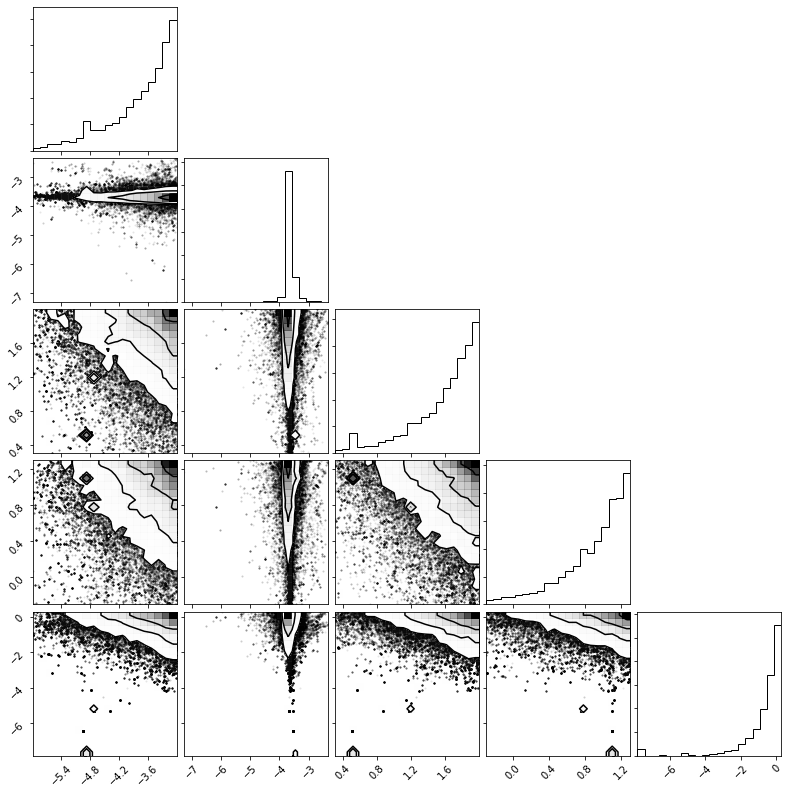

In [8]:
import corner
fig = corner.corner(np.log10(flatchain))

In [8]:
try:
    post_pos
except NameError:
    post_pos = pd.read_csv(save_file,header=None,index_col=0).values[-nwalkers:,:]

In [ ]:
while True:
    post_sampler = emcee.EnsembleSampler(nwalkers, ndim, fitter.par_resfun)
    post_sampler.run_mcmc(post_pos, nsteps);
    post_flatchain = post_sampler.get_chain(flat=True)
    pd.DataFrame(post_flatchain).to_csv(save_file, header=False, mode='a')
    print('Updated at {}'.format(time.strftime('%X %x')))
    post_pos = post_sampler.get_chain()[-1,:,:]

Updated at 15:32:45 09/06/19
Updated at 15:35:47 09/06/19
Updated at 15:38:18 09/06/19
Updated at 15:40:27 09/06/19
Updated at 15:42:21 09/06/19
